# Feature Visualization - Quick Demo

This notebook provides a quick demo of feature visualization using **Mini Lucid TF2**, similar to this [tutorial](https://github.com/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb) of [Lucid](https://github.com/tensorflow/lucid).


## Imports and Setups

In [4]:
import tensorflow as tf
assert tf.__version__.startswith('2')

from mini_lucid_tf2 import objectives, transformations, render

In [5]:
# load a pre-trained model (without specifying any input shape) and freeze its weights
inception_v3 = tf.keras.applications.InceptionV3(include_top=False) 
inception_v3.trainable = False

# specify the size of images (height and width) to be generated
IMAGE_SIZE = 299

87916544/87910968 [==============================] - 1s 0us/step


---
## First Example

In the simplest case, we just need to specify a visualization objective (e.g. a channel) and feed it to the main rendering API.

Step 200


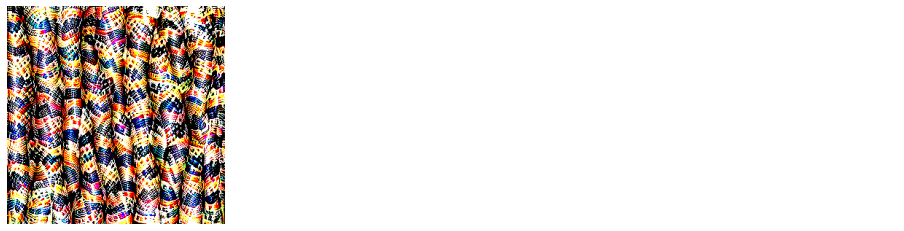

In [6]:
# visualize channel 586 of layer 'mixed4'

obj = objectives.Channel(inception_v3, 'mixed4', 586)
_ = render.render_vis(obj, IMAGE_SIZE)

The main ingredients of producing such visualizations are:

- **objective functions**
- **image parametrization**
- **perturbations** (as regularization)

Each of them will be discussed below.


---
## Objective Functions

The rendering API attempts to maximize an objective function, which mainly serves to represent *what feature to visualize*. In general it can be any (differentiable) function of an image, but in our examples it is mostly the mean activation in a channel of a model.

In [7]:
# multiple objectives can be combined in a batch
# (also showing: intermediate results of optimization, plots of convergence progress)

obj = objectives.Channels(inception_v3, 'mixed4', [37, 290, 476, 586])
_ = render.render_vis(obj, IMAGE_SIZE, steps=[10, 50, 200], display_plots=True)

Output hidden; open in https://colab.research.google.com to view.

**Note.** In the above plots, objective values keep climbing with persistant oscillations, rather than smoothly. This is caused by the perturbations to be discussed below.

Step 200


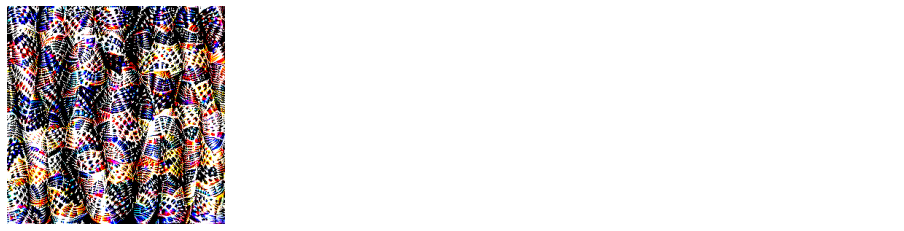

In [8]:
# objectives can also be combined linearly, in one of two equivalent ways

# method 1
obj = objectives.Channel(inception_v3, 'mixed4', 37) + objectives.Channel(inception_v3, 'mixed4', 586) * 0.5

# method 2 (if sharing the same model and layer)
# obj_gen = objectives.LayerObjectiveFactory(inception_v3, 'mixed4')
# obj = obj_gen(objectives.Channel, 37) + obj_gen(objectives.Channel, 586) * 0.5

_ = render.render_vis(obj, IMAGE_SIZE)

---
## Image Parametrization

A parametrization of an image is *a way to represent its degrees of freedom*. While the choice does not impact the maxima of an objective function, it may impact the optimization process and result.

Unlike in [Lucid](https://github.com/tensorflow/lucid), we choose to parametrize images in frequency space only, with two hyperparameters exposed in the rendering API.


Frequency decay rate = 0
Step 200


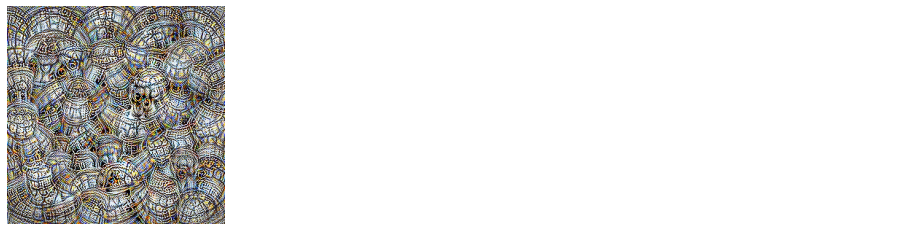

Frequency decay rate = 1 (default)
Step 200


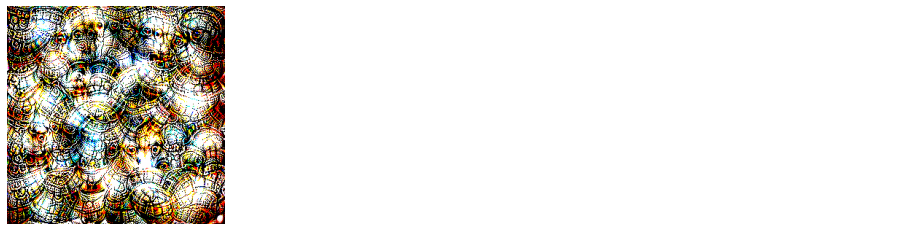

In [9]:
# impact of frequency decay rate 
# (a higher value means more severe down scaling of high frequencies)

obj = objectives.Channel(inception_v3, 'mixed5', 135)

print('Frequency decay rate = 0')
_ = render.render_vis(obj, IMAGE_SIZE, freq_decay=0.0)

print('Frequency decay rate = 1 (default)')
_ = render.render_vis(obj, IMAGE_SIZE, freq_decay=1.0)

Uncorrelated RGB channels
Step 200


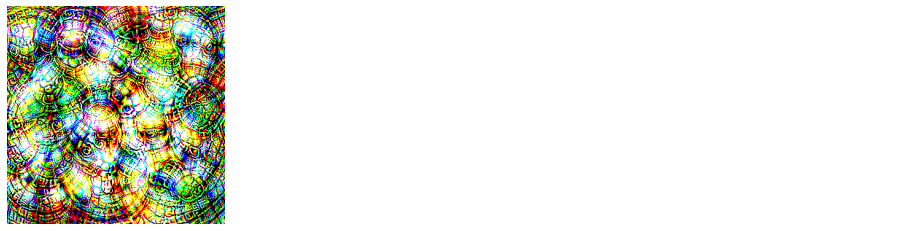

Empirically correlated RGB channels
Step 200


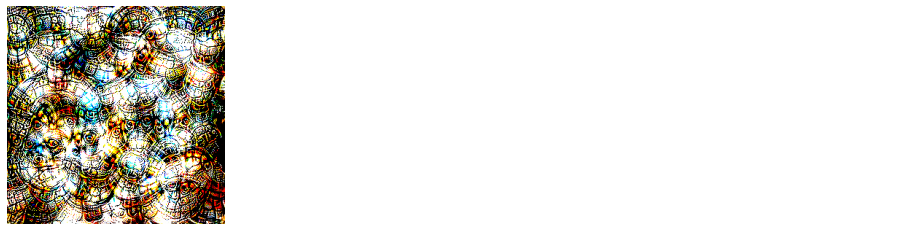

In [10]:
# impact of imposing empirical RGB correlations

obj = objectives.Channel(inception_v3, 'mixed5', 135)

print('Uncorrelated RGB channels')
_ = render.render_vis(obj, IMAGE_SIZE, rgb_corr=False)

print('Empirically correlated RGB channels')
_ = render.render_vis(obj, IMAGE_SIZE, rgb_corr=True)

---
## Regularization via Perturbations

As a way to regularize the optimization process and obtain a more robust result, we can apply small perturbations to the image at every optimization step. 


Applying no perturbations
Step 200


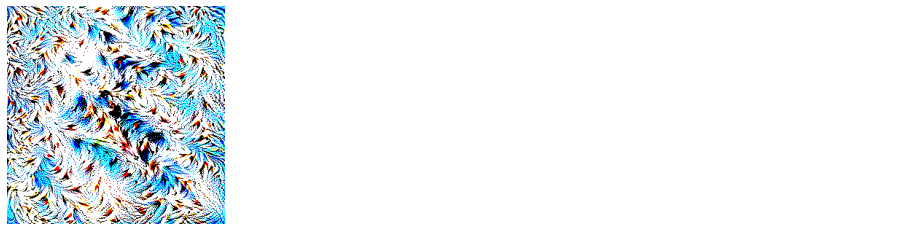

Applying the default perturbations (as in Lucid)
Step 200


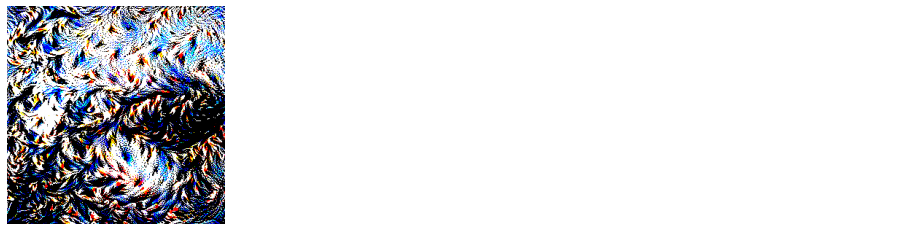

In [11]:
# impact of applying perturbations

obj = objectives.Channel(inception_v3, 'mixed5', 613)

print('Applying no perturbations')
_ = render.render_vis(obj, IMAGE_SIZE, transforms=[])

print('Applying the default perturbations (as in Lucid)')
transforms = [transformations.pad(12), 
              transformations.random_crop(8), 
              transformations.random_scale(0.9, 1.1), 
              transformations.random_rotate(10, p=0.8), 
              transformations.random_crop(4)]

_ = render.render_vis(obj, IMAGE_SIZE, transforms=transforms)

**Note.** In our examples, the effect of perturbations is not as pronounced as shown in the [Lucid tutorial](https://github.com/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb). This may have to do with our use of a different pre-trained model, and will be investigated later.

